**<h3 style="text-align: center; color: #0066FF;">TRANSFORM DATA LOGIN </h3>**

### **1. Extract features**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import collections
tqdm.pandas()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [52]:
df=pd.read_csv("../ingest_from_ITS/data/m952_login_2025-05-01_07-00-00_to_2025-06-26_07-00-00.csv",usecols=[
    "@timestamp", "user.id", 
    "event.its.properties.gold",
    "event.its.properties.diamond","event.its.properties.power_point","event.its.properties.level",
    "event.its.properties.vip_level","event.its.properties.dragon_gold"
    ]) 
df.shape

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Local\Temp\ipykernel_17176\3748666227.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../ingest_from_ITS/data/m952_login_2025-05-01_07-00-00_to_2025-06-26_07-00-00.csv",usecols=[


(21771065, 8)

In [53]:
df['user.id']=df['user.id'].astype(str)

In [54]:
# pd.DataFrame(df['user.id'].unique(), columns=["user.id"]).to_csv("test.csv", index=False, header=True)

In [55]:
df=df[~df['user.id'].isnull()]
df.reset_index(drop=True,inplace=True)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21771065 entries, 0 to 21771064
Data columns (total 8 columns):
 #   Column                            Dtype 
---  ------                            ----- 
 0   @timestamp                        object
 1   user.id                           object
 2   event.its.properties.gold         int64 
 3   event.its.properties.diamond      int64 
 4   event.its.properties.power_point  int64 
 5   event.its.properties.level        int64 
 6   event.its.properties.vip_level    int64 
 7   event.its.properties.dragon_gold  int64 
dtypes: int64(6), object(2)
memory usage: 1.3+ GB


In [57]:
df.head(3)

,@timestamp,user.id,event.its.properties.gold,event.its.properties.diamond,event.its.properties.power_point,event.its.properties.level,event.its.properties.vip_level,event.its.properties.dragon_gold
0,2025-05-03T16:00:00.000Z,2407291943320343,126543,0,57896,20,0,1
1,2025-05-03T16:00:01.000Z,2501112011185624,1116254,0,55850,20,0,1
2,2025-05-03T16:00:01.000Z,2501280114163230,37281272,653,19256634,77,3,1576


In [58]:
df['@timestamp'] = pd.to_datetime(df['@timestamp'], errors='coerce', utc=True)

In [59]:
len(df['user.id'].unique())

217072

In [60]:
df=df.rename(columns={'user.id':'vopenid'})

#### **Visualize**

In [61]:
VS = False

In [62]:
cols_plot = [
    "event.its.properties.gold", "event.its.properties.diamond",
    "event.its.properties.power_point", "event.its.properties.dragon_gold"
]

if VS:
    for col in cols_plot:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

In [63]:
if VS:
    asset_cols = [
        "event.its.properties.gold",
        "event.its.properties.diamond",
        "event.its.properties.dragon_gold"
    ]
    df_corr = df[asset_cols].apply(pd.to_numeric, errors="coerce").corr()

    sns.heatmap(df_corr, annot=True, cmap="coolwarm")
    plt.xticks(rotation=45)
    plt.title("Correlation amongs resources")
    plt.show()

In [64]:
if VS:
    df["event.its.properties.power_point"] = pd.to_numeric(df["event.its.properties.power_point"], errors="coerce")
    df["event.its.properties.level"] = pd.to_numeric(df["event.its.properties.level"], errors="coerce")
    df["event.its.properties.vip_level"] = pd.to_numeric(df["event.its.properties.vip_level"], errors="coerce")

    df_scatter = df.dropna(subset=[
        "event.its.properties.power_point",
        "event.its.properties.level",
        "event.its.properties.vip_level"
    ])

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_scatter,
        y="event.its.properties.power_point",
        x="event.its.properties.level",
        hue="event.its.properties.vip_level",
        palette="coolwarm",
        alpha=0.7,
        edgecolor=None
    )
    plt.title("Power Point vs Level (hue by VIP)")
    plt.xlabel("Level")
    plt.ylabel("Power Point")
    plt.legend(title="VIP Level", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

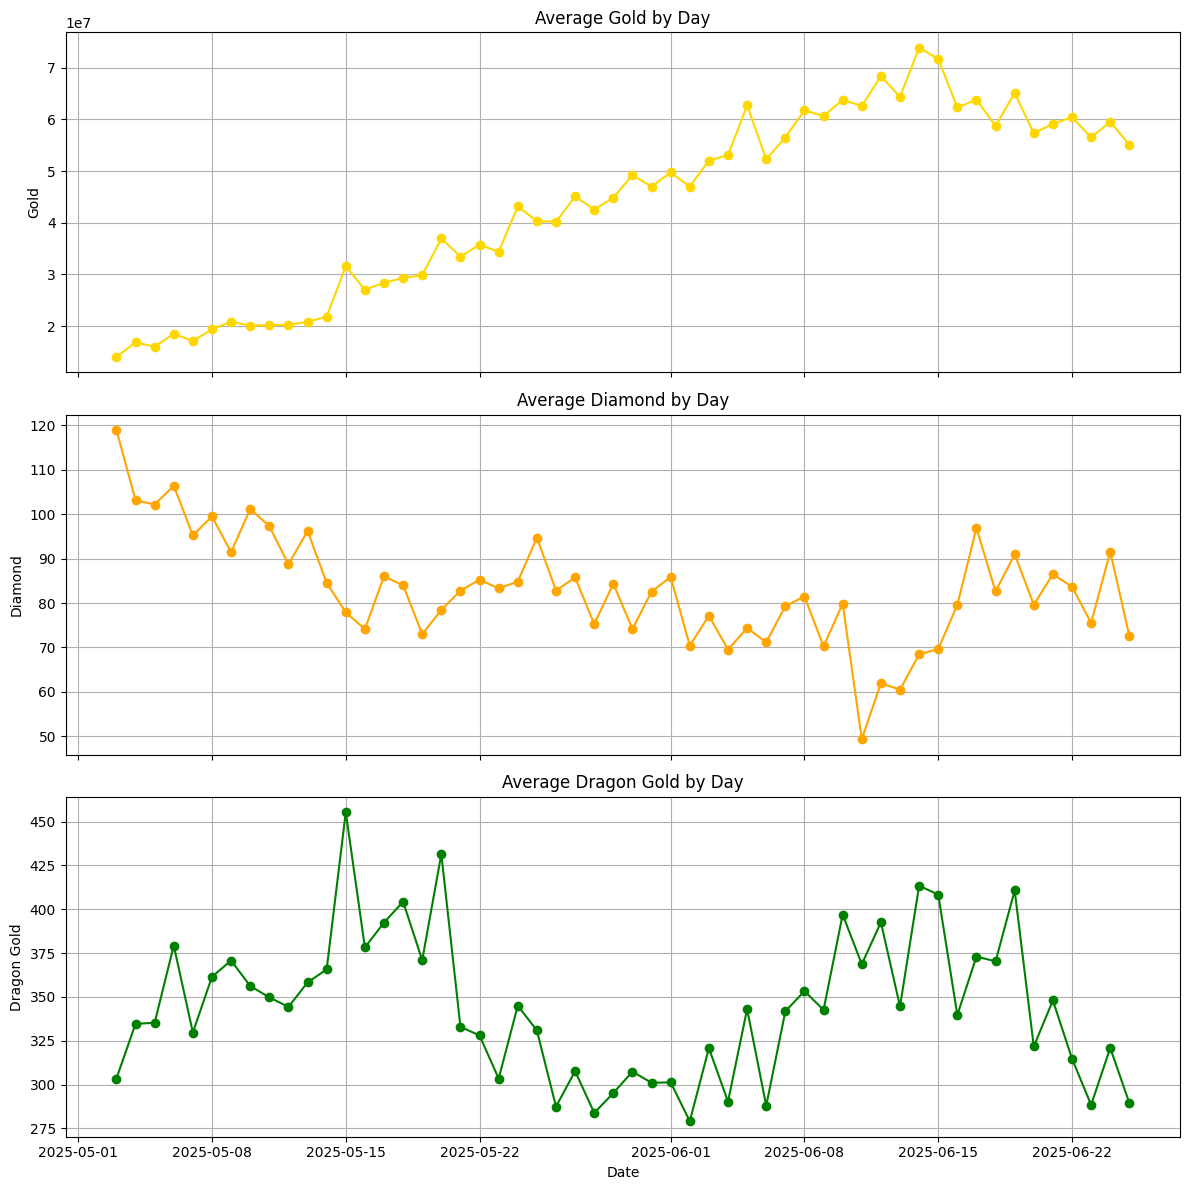

In [65]:
df["date"] = df["@timestamp"].dt.date
daily_assets = df.groupby("date")[[
    "event.its.properties.diamond",
    "event.its.properties.gold",
    "event.its.properties.dragon_gold"
]].mean()

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

axes[0].plot(daily_assets.index, daily_assets["event.its.properties.gold"], color='gold', marker='o')
axes[0].set_ylabel("Gold")
axes[0].set_title("Average Gold by Day")
axes[0].grid(True)

axes[1].plot(daily_assets.index, daily_assets["event.its.properties.diamond"], color='orange', marker='o')
axes[1].set_ylabel("Diamond")
axes[1].set_title("Average Diamond by Day")
axes[1].grid(True)

axes[2].plot(daily_assets.index, daily_assets["event.its.properties.dragon_gold"], color='green', marker='o')
axes[2].set_ylabel("Dragon Gold")
axes[2].set_title("Average Dragon Gold by Day")
axes[2].set_xlabel("Date")
axes[2].grid(True)

plt.tight_layout()
plt.show()

#### **Create features**

In [66]:
now = pd.Timestamp("2025-06-26 23:00:00", tz="UTC") 

In [67]:
df=df.sort_values(by=['@timestamp'])

In [68]:
df['@timestamp'].min(),df['@timestamp'].max()

(Timestamp('2025-05-03 16:00:00+0000', tz='UTC'),
 Timestamp('2025-06-25 23:59:58+0000', tz='UTC'))

In [69]:
df['vopenid'].nunique()

217072

In [70]:
train_end = pd.Timestamp("2025-06-20 00:00:00", tz="UTC")
churn_end = pd.Timestamp("2025-06-25 23:59:59", tz="UTC")

In [71]:
df_train = df[df['@timestamp'] < train_end]
df_churn = df[(df['@timestamp'] >= train_end) & (df['@timestamp'] <= churn_end)]
df_train['vopenid'] = df_train['vopenid'].astype(str).str.strip()
df_churn['vopenid'] = df_churn['vopenid'].astype(str).str.strip()

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Local\Temp\ipykernel_17176\3525952597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['vopenid'] = df_train['vopenid'].astype(str).str.strip()
C:\Users\GOSU.GOSU-TT-ZION1\AppData\Local\Temp\ipykernel_17176\3525952597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_churn['vopenid'] = df_churn['vopenid'].astype(str).str.strip()


In [72]:
# time update
def last_update_time(group):
    last_time = group['@timestamp'].max()
    return {
        'last_update_time': last_time
    }

In [73]:
# count number times that user login
def num_login(group):
    return {
        'num_login': len(group)
    }

In [74]:
# count how many days that user login
def num_day_login(group):
    num_day = group['@timestamp'].dt.date.nunique()
    return {
        "num_day_login":num_day,
    }

In [75]:
cutoff = pd.to_datetime("2025-06-25")

def survival_label(group):
    first = group["@timestamp"].min().date()
    last = group["@timestamp"].max().date()

    duration = (min(last, cutoff.date()) - first).days + 1
    event = int(last < cutoff.date())  

    return pd.Series({
        "duration": duration,
        "event": event,
        "first_login": first,
        "last_login": last
    })

In [76]:
# count how many sessions that user login per day
def num_session_on_day_login(group):
    if group.empty:
        return {
            'num_session_on_day': 0
        }
    group['date'] = group['@timestamp'].dt.date
    daily_counts = group.groupby('date').size()
    avg = daily_counts.mean()
    return {
        'login_frequency': avg
    }

In [77]:
# average days that user login per week
def avg_weekly_login(group):
    times = group['@timestamp'].sort_values()
    total_login = len(times)
    if total_login < 1:
        return {'avg_weekly_login': 0}

    min_day = times.min().date()
    max_day = times.max().date()
    num_weeks = ((max_day - min_day).days // 7) + 1
    avg_week = total_login / num_weeks if num_weeks > 0 else total_login

    return {
        'avg_weekly_login': avg_week
    }

In [78]:
def std_weekly_login(group):
    times = group['@timestamp'].sort_values()
    if len(times) < 2:
        return {'std_weekly_login': 0}
    
    weeks = times.dt.isocalendar().week
    years = times.dt.isocalendar().year
    week_index = list(zip(years, weeks))
    week_counter = collections.Counter(week_index)
    week_counts = list(week_counter.values())
    if len(week_counts) < 2:
        std_week = 0
    else:
        import numpy as np
        std_week = np.std(week_counts, ddof=0) 
    
    return {
        'std_weekly_login': std_week
    }


In [79]:
# the longest streak day that user login
def streak_login(group):
    days = pd.to_datetime(group['@timestamp'].dt.date).sort_values().drop_duplicates()
    streak = 1
    max_streak=1
    for i in range(1, len(days)):
        if (days.iloc[i] - days.iloc[i-1]).days == 1:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 1
    return {
        'streak_login': max_streak
    }

In [80]:
def days_since_last_login(group):
    last_time = group['@timestamp'].max()
    if last_time.tzinfo is None:
        last_time = last_time.tz_localize('UTC')
    res = (train_end - last_time).days
    return {
        'days_since_last_login': res
    }

In [81]:
def short_lifetime_flag(group):
    num_login_days = group['@timestamp'].dt.date.nunique()
    last_login = group['@timestamp'].max()
    if last_login.tzinfo is None:
        last_login = last_login.tz_localize('UTC')
    days_since_last_login = (train_end - last_login).days
    flag = int((num_login_days <= 3) and (days_since_last_login < 7))
    return {'short_lifetime_flag': flag}

In [82]:
# the popular time that user login
def popular_time_login(group):
    hours = group['@timestamp'].dt.hour
    mode = hours.mode()
    res=mode.iloc[0] if not mode.empty else None
    return {
        'popular_time_login': res
    }

In [83]:
# std gold
def std_gold_login(group):
    gold_series = group.sort_values('@timestamp')['event.its.properties.gold']
    if len(gold_series) < 2:
        std_gold = 0.0  
    else:
        std_gold = gold_series.std()
    
    return {
        'gold_std_login': std_gold
    }

In [84]:
# std diamond
def std_diamond_login(group):
    diamond_series = group.sort_values('@timestamp')['event.its.properties.diamond']
    if len(diamond_series) < 2:
        std_diamond = 0.0  
    else:
        std_diamond = diamond_series.std()
    
    return {
        'diamond_std_login': std_diamond
    }

In [85]:
# std silkcoin
def std_silkcoin_login(group):
    silkcoin_series = group.sort_values('@timestamp')['event.its.properties.dragon_gold']
    if len(silkcoin_series) < 2:
        std_silkcoin = 0.0  
    else:
        std_silkcoin = silkcoin_series.std()
    
    return {
        'silkcoin_std_login': std_silkcoin
    }

In [86]:
# the last powerpoint of user
def last_login_powerpoint(group):
    latest = group.sort_values('@timestamp', ascending=False).iloc[0]
    return {
        'powerpoint_last_login': latest['event.its.properties.power_point']
    }

In [87]:
# slope gold
def slope_gold_login(group):
    group_sorted = group.sort_values('@timestamp')
    gold_values = group_sorted['event.its.properties.gold'].values

    n = len(gold_values)
    if n < 2:
        return { 'gold_slope_login': 0.0 }

    x = np.arange(n)
    y = gold_values

    mean_x = x.mean()
    mean_y = y.mean()

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sum((x - mean_x) ** 2)

    slope = numerator / denominator if denominator != 0 else 0.0

    return {
        'gold_slope_login': slope
    }

In [88]:
# slope diamond
def slope_diamond_login(group):
    group_sorted = group.sort_values('@timestamp')
    diamond_values = group_sorted['event.its.properties.diamond'].values

    n = len(diamond_values)
    if n < 2:
        return { 'diamond_slope_login': 0.0 }

    x = np.arange(n)
    y = diamond_values

    mean_x = x.mean()
    mean_y = y.mean()

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sum((x - mean_x) ** 2)

    slope = numerator / denominator if denominator != 0 else 0.0

    return {
        'diamond_slope_login': slope
    }

In [89]:
# slope silkcoin
def slope_silkcoin_login(group):
    group_sorted = group.sort_values('@timestamp')
    silkcoin_values = group_sorted['event.its.properties.dragon_gold'].values

    n = len(silkcoin_values)
    if n < 2:
        return { 'silkcoin_slope_login': 0.0 }

    x = np.arange(n)
    y = silkcoin_values

    mean_x = x.mean()
    mean_y = y.mean()

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sum((x - mean_x) ** 2)

    slope = numerator / denominator if denominator != 0 else 0.0

    return {
        'silkcoin_slope_login': slope
    }

In [90]:
def gold_login_features(group):
    gold_series = group.sort_values('@timestamp')['event.its.properties.gold']
    n = len(gold_series)
    if n == 0:
        return {
            'gold_first': 0.0,
            'gold_last': 0.0,
            'gold_net_per_login': 0.0,
            'gold_max': 0.0,
            'gold_min': 0.0,
            'gold_trend_strength': 0.0
        }
    gold_first = gold_series.iloc[0]
    gold_last = gold_series.iloc[-1]
    gold_max = gold_series.max()
    gold_min = gold_series.min()
    net_change = gold_last - gold_first
    net_per_login = net_change / n if n > 0 else 0.0
    from scipy.stats import kendalltau
    if n > 1:
        tau, _ = kendalltau(range(n), gold_series)
        trend_strength = tau if not np.isnan(tau) else 0.0
    else:
        trend_strength = 0.0
    return {
        'gold_first': gold_first,
        'gold_last': gold_last,
        'gold_net_per_login': net_per_login,
        'gold_max': gold_max,
        'gold_min': gold_min,
        'gold_trend_strength': trend_strength
    }

In [91]:
def diamond_login_features(group):
    diamond_series = group.sort_values('@timestamp')['event.its.properties.diamond']
    n = len(diamond_series)
    if n == 0:
        return {
            'diamond_first': 0.0,
            'diamond_last': 0.0,
            'diamond_net_per_login': 0.0,
            'diamond_max': 0.0,
            'diamond_min': 0.0,
            'diamond_trend_strength': 0.0
        }
    diamond_first = diamond_series.iloc[0]
    diamond_last = diamond_series.iloc[-1]
    diamond_max = diamond_series.max()
    diamond_min = diamond_series.min()
    net_change = diamond_last - diamond_first
    net_per_login = net_change / n if n > 0 else 0.0
    from scipy.stats import kendalltau
    if n > 1:
        tau, _ = kendalltau(range(n), diamond_series)
        trend_strength = tau if not np.isnan(tau) else 0.0
    else:
        trend_strength = 0.0
    return {
        'diamond_first': diamond_first,
        'diamond_last': diamond_last,
        'diamond_net_per_login': net_per_login,
        'diamond_max': diamond_max,
        'diamond_min': diamond_min,
        'diamond_trend_strength': trend_strength
    }

In [92]:
def silkcoin_login_features(group):
    silkcoin_series = group.sort_values('@timestamp')['event.its.properties.dragon_gold']
    n = len(silkcoin_series)
    if n == 0:
        return {
            'silkcoin_first': 0.0,
            'silkcoin_last': 0.0,
            'silkcoin_net_per_login': 0.0,
            'silkcoin_max': 0.0,
            'silkcoin_min': 0.0,
            'silkcoin_trend_strength': 0.0
        }
    silkcoin_first = silkcoin_series.iloc[0]
    silkcoin_last = silkcoin_series.iloc[-1]
    silkcoin_max = silkcoin_series.max()
    silkcoin_min = silkcoin_series.min()
    net_change = silkcoin_last - silkcoin_first
    net_per_login = net_change / n if n > 0 else 0.0
    from scipy.stats import kendalltau
    if n > 1:
        tau, _ = kendalltau(range(n), silkcoin_series)
        trend_strength = tau if not np.isnan(tau) else 0.0
    else:
        trend_strength = 0.0
    return {
        'silkcoin_first': silkcoin_first,
        'silkcoin_last': silkcoin_last,
        'silkcoin_net_per_login': net_per_login,
        'silkcoin_max': silkcoin_max,
        'silkcoin_min': silkcoin_min,
        'silkcoin_trend_strength': trend_strength
    }

In [93]:
# level of user
def last_login_level(group):
    latest = group.sort_values('@timestamp', ascending=False).iloc[0]
    return {
        'level_last_login': latest['event.its.properties.level']
    }

In [94]:
# vip of user
def last_login_vip(group):
    latest = group.sort_values('@timestamp', ascending=False).iloc[0]
    return {
        'vip_last_login': latest['event.its.properties.vip_level']
    }

In [95]:

features_function=[
   last_update_time,
   num_login,
   num_day_login,
   num_session_on_day_login,
   avg_weekly_login,
   std_weekly_login,
   streak_login,
   days_since_last_login,
   popular_time_login,
   std_gold_login,
   std_diamond_login,
   std_silkcoin_login,
   slope_gold_login,
   slope_diamond_login,
   slope_silkcoin_login,
   # gold_login_features,
   # diamond_login_features,
   # silkcoin_login_features,
   short_lifetime_flag,
   last_login_powerpoint,
   last_login_level,
   last_login_vip,
   survival_label,
]

In [96]:
def extract_group_features(group):
    result={}
    for func in features_function:
        try:
            result.update(func(group))
        except Exception as e:
            print(f"Error at feature: {func}. Error: {e}")
    return pd.Series(result)

df_res = df_train.groupby(['vopenid']).progress_apply(extract_group_features).reset_index()
df_res

100%|██████████| 201416/201416 [10:33<00:00, 318.06it/s]


,vopenid,last_update_time,num_login,num_day_login,login_frequency,avg_weekly_login,std_weekly_login,streak_login,days_since_last_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,short_lifetime_flag,powerpoint_last_login,level_last_login,vip_last_login,duration,event,first_login,last_login
0,2206111754266455,2025-05-08 11:08:20+00:00,2,2,1.00,2.00,0.00,2,42,10,12632.46,0.00,0.00,17865.00,0.00,0.00,0,29366,9,0,2,1,2025-05-07,2025-05-08
1,2206111758351763,2025-05-26 05:07:07+00:00,1,1,1.00,1.00,0.00,1,24,5,0.00,0.00,0.00,0.00,0.00,0.00,0,25359,1,0,1,1,2025-05-26,2025-05-26
2,2206111808105074,2025-06-16 02:01:16+00:00,6,2,3.00,6.00,1.00,2,3,1,191511.83,0.41,0.00,61253.34,-0.14,0.00,1,74275,21,0,2,1,2025-06-15,2025-06-16
3,2206111830413361,2025-06-19 14:54:55+00:00,164,47,3.49,23.43,6.91,36,0,22,7644571.91,0.00,22.76,-107508.44,0.00,-0.21,0,288173,28,0,48,1,2025-05-03,2025-06-19
4,2206111904162575,2025-05-20 01:58:44+00:00,1,1,1.00,1.00,0.00,1,30,1,0.00,0.00,0.00,0.00,0.00,0.00,0,24938,1,0,1,1,2025-05-20,2025-05-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201411,lkeu,2025-06-18 06:40:34+00:00,2,2,1.00,2.00,0.00,1,1,6,3558.87,0.00,0.00,5033.00,0.00,0.00,1,24218,3,0,7,1,2025-06-12,2025-06-18
201412,lknew,2025-06-12 04:50:52+00:00,4,2,2.00,1.33,1.00,1,7,3,4839.08,0.00,0.00,2800.00,0.00,0.00,0,479146,36,0,16,1,2025-05-28,2025-06-12
201413,tri3,2025-06-16 08:20:13+00:00,2,1,2.00,2.00,0.00,1,3,5,0.00,0.00,0.00,0.00,0.00,0.00,1,26467,1,0,1,1,2025-06-16,2025-06-16
201414,vtvinh,2025-06-17 07:10:48+00:00,9,3,3.00,9.00,3.50,2,2,6,186669.67,0.00,0.00,52153.97,0.00,0.00,1,106968,23,0,7,1,2025-06-11,2025-06-17


In [97]:
df_res['vopenid'] = df_res['vopenid'].astype(str).str.strip()
df_res.shape

(201416, 24)

In [98]:
login_in_churn_window = set(df_churn['vopenid'].unique())
df_res['churn'] = df_res['vopenid'].apply(
    lambda x: 0 if x in login_in_churn_window else 1
)

In [99]:
df_res.to_csv("data/login_transform.csv",index=False,header=True)

In [100]:
df_res['vopenid'].nunique()

201416